In [1]:
# Hacky. Local module import
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import random
from glob import glob
from natsort import natsorted
import numpy as np
from pathlib import PosixPath

from tqdm.autonotebook import tqdm
from fastprogress import master_bar, progress_bar

import torch
from torch.utils.data import DataLoader
import torchvision

import rasterio

from sen12ms.dataloader import sen12ms

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
data_path = PosixPath("/mnt/data")
random.seed(42)

First, it's assumed that you extracted SEN1-2MS to `/mnt/data`, so change the path above if you didn't.

Let's open a Sentinel 2 image and limit to the RGB bands, so the image below is true colour.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


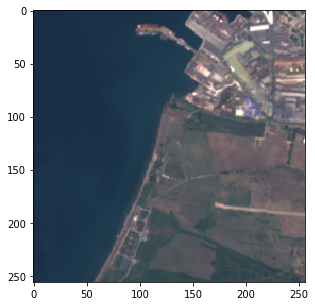

In [4]:
plt.figure(figsize=(5,5))
im = rasterio.open(data_path/"ROIs1868_summer/s2_100/ROIs1868_summer_s2_100_p112.tif").read()
plt.imshow(im[(3,2,1),:,:].transpose(1,2,0)/3200)

These images have a high dynamic range (12-bit). Intensities are first divided by 3200 (looks a bit better than 4096)

<img src="https://s3.amazonaws.com/content.satimagingcorp.com/media/cms_page_media/1530/image001.png" alt="drawing" style="width:400px;"/>

Weird stuff happens if you highlight certain bands, for example displaying NIR as the red channel tends to highlight vegetation, which strongly reflects NIR light (hence why plants are green). We also display SWIR as the blue channel which has a low apparent reflectance and appears almost black.

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(im[(8,3,12),:,:].transpose(1,2,0)/3200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


What do the rest of the bands look like? Note that some of them (e.g. band 0) are lower resolution, up to 60m.

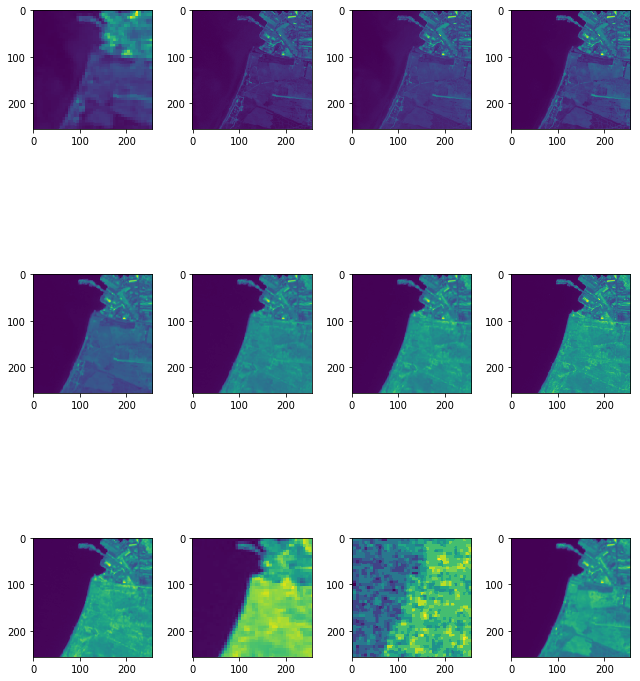

In [6]:
plt.figure(figsize=(9,12))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(im[i])
plt.tight_layout()
plt.show()

Now let's look at the SAR image. Firstly it's clear how noisy this data is. It's also interesting to see that (coincidentally) in this image there seems to be an extremely RADAR-reflective location, but it's only strong in the vertical signal.

Note that while water is "dark" as it absorbs the RADAR signal, there is still a good deal of noise compared to e.g. SWIR at 2 micron (band 13).

Text(0.5, 1.0, 'Horizontal Polarisation')

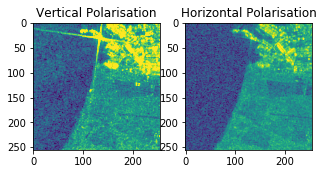

In [7]:
plt.figure(figsize=(5,5))
sar_im = rasterio.open(data_path/"ROIs1868_summer/s1_100/ROIs1868_summer_s1_100_p112.tif").read()

plt.subplot(121)
plt.imshow(sar_im[0])
plt.title("Vertical Polarisation")

plt.subplot(122)
plt.imshow(sar_im[1])
plt.title("Horizontal Polarisation")

We can overplot this to see that it's probably a building of some kind:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


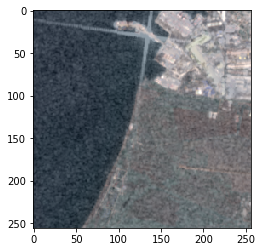

In [8]:
plt.imshow(im[(3,2,1),:,:].transpose(1,2,0)/3200)
plt.imshow(sar_im[0], cmap='gray', alpha=0.5)

Finally let's look at the ground truth for this patch. These are derived from MODIS at 500m resolution (not great). The colours correspond to the IGBP scale:

1. Evergreen needleleaf
2. Evergreen broadleaf
3. Deciduous needleleaf
4. Deciduous broadleaf
5. Mixed forest
6. Closed shrubland
7. Open shrubland
8. Woody savannas
9. Savannas
10. Grasslands
11. Permanent wetlands
12. Croplands
13. Urban and built-up lands
14. Cropland/natural vegetation mosaics
15. Permanent snow and ice
16. Barren
17. Water bodies

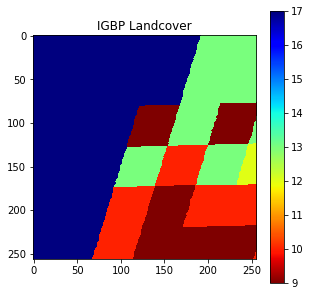

In [9]:
plt.figure(figsize=(5,5))
lc_im = rasterio.open(data_path/"ROIs1868_summer/lc_100/ROIs1868_summer_lc_100_p112.tif").read()
plt.imshow(lc_im[0], cmap='jet_r')
plt.title("IGBP Landcover")
plt.colorbar()

Finally let's load the whole thing as a PyTorch dataset (RGB only for now):

In [10]:
dataset = sen12ms(data_path, rgb=True)

Make a dataloader so we can inspect a batch:

In [11]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Let's visualise one of the batches:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


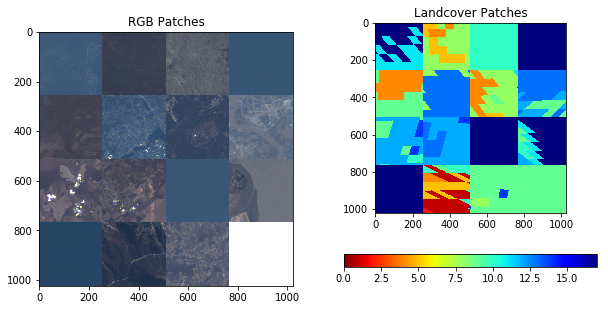

In [12]:
plt.figure(figsize=(10,5))
nrow = 4

imgs, labels = next(iter(dataloader))

# Reverse mean correction
rgb_mean = torch.from_numpy(dataset.mean_optical_image[(3,2,1),:,:])
imgs = [(img.double()*4096 + rgb_mean.double())/3200 for img in imgs]

img = torchvision.utils.make_grid(imgs, padding=0,nrow=nrow).numpy()
img = img.transpose((1,2,0))

plt.subplot(121)
plt.imshow(img)
plt.title("RGB Patches")

# Fix dimensions to plot properly
labels = np.argmax(labels.reshape((-1,18,256,256)), axis=1).reshape((-1, 1, 256, 256))
label = torchvision.utils.make_grid(labels,padding=0,nrow=nrow).numpy()
label = label.transpose((1,2,0)).mean(2)

plt.subplot(122)
plt.imshow(label, cmap='jet_r', vmin=0, vmax=17)
plt.title("Landcover Patches")
plt.colorbar(orientation='horizontal')

The images on the left are Sentinel 2 images in the optical band. If you re-run the above cell, you will get a new random sample from the dataset.

Looking at the dataset mean, there's clearly some fixed pattern noise, but the magnitude is very low (around 5 counts across the frame):

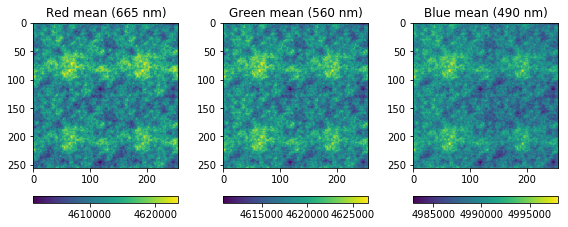

In [13]:
plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(rgb_mean[0]*4096)
plt.title("Red mean (665 nm)")
plt.colorbar(orientation='horizontal', pad=0.05)
plt.subplot(132)
plt.imshow(rgb_mean[1]*4096)
plt.title("Green mean (560 nm)")
plt.colorbar(orientation='horizontal', pad=0.05)
plt.subplot(133)
plt.imshow(rgb_mean[2]*4096)
plt.title("Blue mean (490 nm)")
plt.colorbar(orientation='horizontal', pad=0.05)
plt.tight_layout()